In [253]:
import math
import os
import random
from pathlib import Path
import numpy as np
import yaml
import glob
import cv2
import torch
from pathlib import Path
import pandas as pd
import json
from pycocotools.coco import COCO
from PIL import Image, ImageDraw
import matplotlib.patches as patches
import copy

np.random.seed(42)
random.seed(42)

IMAGE_NUM = 1000

def myFig(img, bbox, drawB = True) :
    image = Image.fromarray(img,"RGB")
    draw = ImageDraw.Draw(image)

    if drawB :
        for i in range(len(bbox)) :
            xmin = bbox[i][1] 
            ymin = bbox[i][2]
            xmax = bbox[i][3]
            ymax = bbox[i][4]

            draw.rectangle((xmin, ymin, xmax, ymax), outline=(255,0,0), width = 1) # bounding box
#     display(image)
    return image

def xyxy(bbox):
    new_bbox = np.copy(bbox)
    new_bbox[:, 3] = bbox[:, 1] + bbox[:, 3]
    new_bbox[:, 4] = bbox[:, 2] + bbox[:, 4]
    return new_bbox

def xywh(bbox):
    new_bbox = copy.deepcopy(bbox)
    new_bbox[3] = bbox[3] - bbox[1]
    new_bbox[4] = bbox[4] - bbox[2]
    return new_bbox

In [254]:
def create_image_info(image_id, file_name):

    image_info = {
            "id": image_id,
            "file_name": file_name,
            "width": 1024,
            "height": 1024,
            "date_captured": '2022-11-25 14:44:23',
            "license": 0,
            "coco_url": None,
            "flickr_url": None
    }

    return image_info

def create_annotation_info(annotation_id, image_id, bounding_box):

    bounding_box = xywh(bounding_box)
    area = bounding_box[3] * bounding_box[4]
    
    annotation_info = {
        "id": annotation_id,
        "image_id": image_id,
        "category_id": bounding_box[0],
        "iscrowd": 0,
        "area": area,
        "bbox": bounding_box[1:]
    } 

    return annotation_info

In [255]:
def update_image_and_anno(all_img_list, im_list, coco, idxs, output_size, scale_range, filter_scale=0.):
    output_img = np.zeros([output_size[0], output_size[1], 3], dtype=np.uint8)
    scale_x = scale_range[0] + random.random() * (scale_range[1] - scale_range[0])
    scale_y = scale_range[0] + random.random() * (scale_range[1] - scale_range[0])
    divid_point_x = int(scale_x * output_size[1])
    divid_point_y = int(scale_y * output_size[0])
    random.shuffle(idxs)

    new_anno = []
    for i, idx in enumerate(idxs):
        path = all_img_list[idx]
        label_list = coco.getAnnIds(imgIds=im_list[idx])
        label_box = coco.loadAnns(label_list)
        img_annos = xyxy(np.array([[d['category_id']] + d['bbox'] for d in label_box]))

        img = cv2.imread(path)
        if i == 0:  # top-left
            img = cv2.resize(img, (divid_point_x, divid_point_y))
            output_img[:divid_point_y, :divid_point_x, :] = img
            for bbox in img_annos:
                xmin = bbox[1] * scale_x
                ymin = bbox[2] * scale_y
                xmax = bbox[3] * scale_x
                ymax = bbox[4] * scale_y
                new_anno.append([bbox[0], xmin, ymin, xmax, ymax])

        elif i == 1:  # top-right
            img = cv2.resize(img, (output_size[1] - divid_point_x, divid_point_y))
            output_img[:divid_point_y, divid_point_x:output_size[1], :] = img
            for bbox in img_annos:
                xmin = divid_point_x + bbox[1] * (1 - scale_x)
                ymin = bbox[2] * scale_y
                xmax = divid_point_x + bbox[3] * (1 - scale_x)
                ymax = bbox[4] * scale_y
                new_anno.append([bbox[0], xmin, ymin, xmax, ymax])
        elif i == 2:  # bottom-left
            img = cv2.resize(img, (divid_point_x, output_size[0] - divid_point_y))
            output_img[divid_point_y:output_size[0], :divid_point_x, :] = img
            for bbox in img_annos:
                xmin = bbox[1] * scale_x
                ymin = divid_point_y + bbox[2] * (1 - scale_y)
                xmax = bbox[3] * scale_x
                ymax = divid_point_y + bbox[4] * (1 - scale_y)
                new_anno.append([bbox[0], xmin, ymin, xmax, ymax])
        else:  # bottom-right
            img = cv2.resize(img, (output_size[1] - divid_point_x, output_size[0] - divid_point_y))
            output_img[divid_point_y:output_size[0], divid_point_x:output_size[1], :] = img
            for bbox in img_annos:
                xmin = divid_point_x + bbox[1] * (1 - scale_x)
                ymin = divid_point_y + bbox[2] * (1 - scale_y)
                xmax = divid_point_x + bbox[3] * (1 - scale_x)
                ymax = divid_point_y + bbox[4] * (1 - scale_y)
                new_anno.append([bbox[0], xmin, ymin, xmax, ymax])

    if 0 < filter_scale:
        new_anno = [anno for anno in new_anno if
                    filter_scale < (anno[3] - anno[1]) and filter_scale < (anno[4] - anno[2])]

    return output_img, new_anno

In [256]:
OUTPUT_SIZE = (1024, 1024)  # Height, Width
SCALE_RANGE = (0.3, 0.7)
FILTER_TINY_SCALE = 1 / 10  # if height or width lower than this scale, drop it.

img_size = 1024
path = '/opt/ml/dataset'

jsonpath = os.path.join(path, 'K-fold_train1.json')
trainjson = COCO(jsonpath)
im_list = trainjson.getImgIds()
im_files = [os.path.join(path, 'train', f"{i:04d}") + '.jpg' for i in im_list]

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [257]:
bat = trainjson.getImgIds(catIds=8)
bat_idx = []
for b in bat:
    bat_idx.append(im_list.index(b))
bat_idx = sorted(bat_idx)

clothing = trainjson.getImgIds(catIds=9)
clo_idx = []
for c in clothing:
    clo_idx.append(im_list.index(c))
clo_idx = sorted(clo_idx)

In [261]:
img_list, ann_list = [], []
img_files = [os.path.join(path, 'aug', f"{i:04d}") + '.jpg' for i in range(1000)]
anno_num = 0
# new_img_list = []
# new_ann_list = []

for image_id in range(IMAGE_NUM):
    p = np.random.rand(1)

    if p < 0.5: idxs = random.sample(range(len(im_files)), 4)
    elif p >= 0.5 and p < 0.7: 
        battery = random.choice(bat_idx)
        idxs = random.sample(range(len(im_files)), 3)
        idxs.append(battery)
    else:
        battery = random.choice(bat_idx)
        cloth = random.choice(clo_idx)
        idxs = random.sample(range(len(im_files)), 2)
        idxs.append(battery)
        idxs.append(cloth)

    new_image, new_annos = update_image_and_anno(im_files, im_list,
                                                 trainjson,
                                                 idxs,
                                                 OUTPUT_SIZE, SCALE_RANGE,
                                                 filter_scale=FILTER_TINY_SCALE)
    cv2.imwrite(img_files[image_id], new_image)
    
    # new_img_list.append(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
    # new_ann_list.append(new_annos)
    
    img_info = create_image_info(image_id = image_id, file_name = img_files[image_id])
    img_list.append(img_info)
    for anno in new_annos:
        ann_info = create_annotation_info(annotation_id = anno_num, image_id = image_id, bounding_box = anno)
        ann_list.append(ann_info)
        anno_num += 1

In [262]:
master_obj = {'images':[], 'annotations':[], 'categories':[]}

l = []
for i in range(10):
    l += trainjson.loadCats(i)
master_obj['categories'] = l
master_obj['images'] = img_list
master_obj['annotations'] = ann_list

In [263]:
output_path = '/opt/ml/dataset/aug_test.json'
with open(output_path, 'w+') as output_file:
    json.dump(master_obj, output_file)

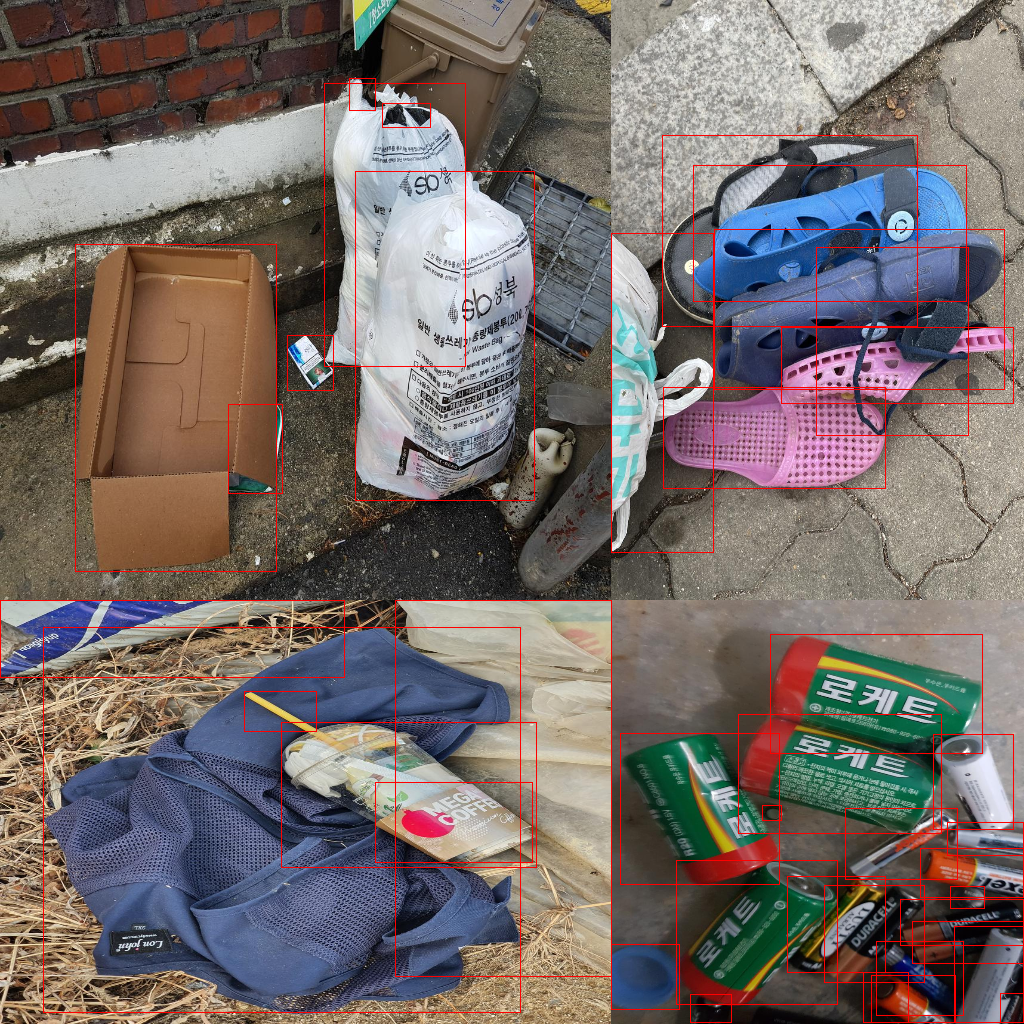

In [244]:
myFig(new_img_list[1], new_ann_list[1])